# Notebook Set I

---

## 02 - OFDM Python Transceiver

Following on from OFDM Fundamentals, this notebook introduces the major components of an OFDM transceiver. This includes a demonstration of multipath channel estimation and the one-tap or Zero Forcing (ZF) equaliser.

* Review major steps in OFDM transmitter
* Pass signal through multipath channel and add AWGN noise
* Review major steps in OFDM receiver
* Demonstrate channel estimation and the one-tap equaliser

##  Table of Contents

* [1. Introduction](#introduction)
* [2. OFDM Transmitter](#ofdmtx)
   * [2.1. Training Symbol Generation](#training)
   * [2.2. OFDM Symbol Generation](#data)
* [3. Wireless Channel](#channel)
* [4. OFDM Receiver](#ofdmrx)
   * [4.1. Channel Estimation](#chanest)
   * [4.2. Channel Equalisation](#chaneq)
* [5. Conclusion](#conclusion)

## Revision
* **v1.0** | 05/12/22 | *First Revision*

---


## 1. Introduction <a class="anchor" id="introduction"></a>

In this notebook, an overview of the main steps in an OFDM transceiver are provided. On the transmit side, this includes symbol generation, IFFT modulation and Cyclic Prefix (CP) addition. The OFDM signal is then passed through a baseband channel model, including multipath channel filter and Additive White Gaussian Noise (AWGN). The receiver stages include CP removal, FFT demodulation, channel estimation and one-tap equalisation. In order to assess the quality of the received signal, we inspect the received constellations before and after equalisation.

We will also mention some important aspects of the OFDM transceiver which are not explicitly covered in this notebook, such as timing and frequency synchronisation.    

## 2. OFDM Transmitter <a class="anchor" id="ofdmtx"></a>

In this section, we will demonstrate some of the main steps in an OFDM transmitter. Firstly, let's import the necessary libraries and helper functions:

In [2]:
!pip install https://github.com/strath-sdr/RFSoC-Book/archive/v1.1.0.tar.gz

     \ 14.8 MB 20.3 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.1/31.1 MB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     | 2.6 MB 33.7 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rfsoc_book: filename=rfsoc_book-1.1.0-py3-none-any.whl size=14854717 sha256=4afca3a469aae7d886a47f53dd26eebd8fa237ff82cf7760a3213fd7863bdeee
  Stored in directory: /tmp/pip-ephem-wheel-cache-25a3qn0y/wheels/88/8a/e5/7fa002db0061a12bfb0f8f10aad806632d2079be8bb413b1ca
  Created wheel for rfsoc_freqplan: filename=rfsoc_freqplan-0.3.3-py3-none-any.whl size=14532 sha256=85516d19ffefdb570934524ac4102d5a3ed55d3eaa303037e622d016fd4e5631
  Stored in directory: /tmp/pip-ephem-wheel-cache-25a3qn0y/wheels/f7/76/4c/0dcca5cb59fb704148b33275a27b2b6d8c453a5add9c77e9ce
  Created wheel for strath_sdfec: filename=strath_sdfec-1.1.0-py3-none-any.whl size=7627757 sha256=af55a8abc7cbc0a240fd3782940e072ae09f6f0264cc0e4fc6fdf

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal

# Import helper function
from rfsoc_book.helper_functions import symbol_gen, psd, \
frequency_plot, scatterplot, calculate_evm, awgn

Figure 1 shows the stages of the OFDM transmitter that will be demonstrated in this notebook:

<figure>
<img src="https://github.com/tvy14/RFSoC-Book/blob/main/rfsoc_book/notebooks/notebook_I/images/ofdm_tx_3%20copy.svg?raw=1" style="width: 1000px;"/>
    <figcaption><b>Figure 1: OFDM transmitter design.</b></figcaption>
</figure>    

This is very similar to the final OFDM transmitter diagram shown in [OFDM Fundamentals](01_ofdm_fundamentals.ipynb). However, we have now addded a sub-carrier mapping stage after symbol generation. This is necessary because in real OFDM systems, only particular sub-carriers are used to carry data. The remaining sub-carriers are used to carry pilots for phase tracking and channel estimation in the receiver and null sub-carriers to relax the requirements for anti-imaging and anti-aliasing filters in the transmitter and receiver respectively.  

In this notebook, we will use the OFDM symbol structure and sub-carrier mapping scheme employed in the IEEE 802.11a/g (Wi-Fi) standard. However, we will restrict ourselves to the addition of null sub-carriers, since we will not demonstrate phase tracking and will employ training symbols for channel estimation.

Let's set some important OFDM parameters:

In [4]:
fs = 20e6 # Sampling rate
N = 64 # No. of sub-carriers

### 2.1. Training Symbol Generation <a class="anchor" id="training"></a>

As mentioned previously, channel estimation will be performed using training symbols, known to both transmitter and receiver. This will be based on the Legacy Long Training Field (L-LTF), used in the IEEE 802.11a/g standard. The L-LTF consists of two training OFDM symbols (each with length $N$ = 64) preceded by a 32 sample CP. As a result, it is 160 samples long.  

The generation of the L-LTF is based on the following sequence:

In [5]:
#L-LTF sequence
LTFseq = np.array([0,0,0,0,0,0,1,1,-1,\
                  -1,1,1,-1,1,-1,1,1,1,\
                  1,1,1,-1,-1,1,1,-1,1,\
                  -1,1,1,1,1,0,1,-1,-1,\
                  1,1,-1,1,-1,1,-1,-1,\
                  -1,-1,-1,1,1,-1,-1,1,\
                  -1,1,-1,1,1,1,1,0,0,0,\
                  0,0])

In reference to Figure 1, we have already completed the symbol generation and sub-carrier mapping stages. A total of 52 Binary Phase Shift Keying (BPSK) symbols have been generated (1,-1) and have been mapped to 52 OFDM sub-carriers. The remaining 12 sub-carriers are set to zero and these are the null sub-carriers. This includes the DC sub-carrier at the centre of the spectrum, 6 on the left edge of the frequency band and 5 on the right edge.   

We can now perform the IFFT to generate the training symbol:

In [6]:
LTFsymb = np.fft.ifft(np.fft.fftshift(LTFseq),N)

An FFT shift is performed to map the symbols to the correct IFFT bins. This is because the IFFT operates from $[0, f_{s})$, whereas the sub-carriers are mapped assuming a frequency range $[-f_{s}/2, f_{s}/2)$.  

Finally, to generate the L-LTF, we repeat the symbol twice and add a 32 sample CP.

In [7]:
# Extract 32 sample CP
LTFcp = LTFsymb[32:64]

# Concatenate to form L-LTF
LLTF = np.concatenate((LTFcp, LTFsymb, LTFsymb))

The L-LTF is used for channel estimation in this notebook. However, it can also be used for fine timing synchronisation, fine frequency synchronisation and integer frequency offset estimation in the receiver. In the IEEE 802.11a/g standard, another training symbol called the Legacy Short Training Field (L-STF) is also used. This will not be covered here. However, it can be used for Automatic Gain Control (AGC) convergence, timing synchronisation and frequency offset estimation.   

### 2.2. OFDM Symbol Generation <a class="anchor" id="data"></a>

Having created the L-LTF, we will now go on to generate our data payload. This consists of a variable number of OFDM symbols carrying randomly generated (BPSK,QPSK,16-QAM) data symbols. We will add a CP of length $N/4 = 16$ samples to each OFDM symbol.
Let's generate a block of $N_{ofdm}N_{data}$ data symbols, where $N_{ofdm}$ is the number of OFDM symbols in the payload and $N_{data}$ is the number of data carrying sub-carriers:  

In [8]:
n_ofdm = 1000 # No. of OFDM symbols
n_data = 52 # No. of data sub-carriers
nsym = n_ofdm * n_data # No. of data symbols
mod_scheme = 'QPSK' # Modulation scheme

# Generate data symbols
data = symbol_gen(nsym,mod_scheme)

We will now perform sub-carrier mapping and IFFT modulation to obtain the OFDM symbols. The data symbols will be mapped in the same manner as the L-LTF sequence and there will be null sub-carriers at DC and on the band edges.

In [9]:
# Indices for data sub-carriers
ind_1 = np.arange(start=6, stop=32)
ind_2 = np.arange(start=33, stop=59)
index = np.concatenate((ind_1, ind_2), axis=0)

# Initialisation of array to hold OFDM symbols
ofdm_data = np.zeros(n_ofdm*N,np.complex64)
j = 0
k = 0

for i in range(n_ofdm):

    # Initialise array to hold data and null sub-carriers
    # (all null to begin with)
    sc_array = np.zeros(N,np.complex64)

    # Map data symbols to correct sub-carrier positions
    sc_array[index] = data[j:j+n_data]

    # Perform IFFT modulation
    ofdm_data[k:k+N] = np.fft.ifft(np.fft.fftshift(sc_array),N)

    # Increment
    j = j + n_data
    k = k + N

We will now add the 16 sample CP to the beginning of each OFDM symbol:

In [10]:
# Define function to add CP
def add_cp(ofdm_symb,N,cp_len):

    #Extract CP
    cp = ofdm_symb[N-cp_len:N:1]

    # Concatenate CP and symbol
    ofdm_symb_cp = np.concatenate((cp,ofdm_symb))

    return ofdm_symb_cp

cp_len = N // 4 # CP length is 1/4 of symbol period

# Add CP to each of the ofdm symbols
ofdm_data_cp = np.zeros(n_ofdm*(N+cp_len),np.complex64)
j = 0
k = 0

for i in range(n_ofdm):
    ofdm_data_cp[k:(k+N+cp_len)] = add_cp(ofdm_data[j:j+N],N,cp_len)
    j = j + N
    k = k + N + cp_len

In order to create the final transmit signal, we attach the L-LTF at the beginning of the data payload. As such, the L-LTF is transmitted first:

In [11]:
# Concatenate L-LTF and data payload to form final transmit signal
txSig = np.concatenate((LLTF,ofdm_data_cp))

## 3. Wireless Channel <a class="anchor" id="channel"></a>

At this stage, we will pass the OFDM signal through a baseband model of the wireless channel. The channel is comprised of a multipath filter and AWGN as illustrated below:  

<figure>
<img src="https://github.com/tvy14/RFSoC-Book/blob/main/rfsoc_book/notebooks/notebook_I/images/channel%20copy.svg?raw=1" style="width: 700px;"/>
    <figcaption><b>Figure 2: Baseband channel model. </b></figcaption>
</figure>

For the multipath channel filter, we will employ a standard 4-tap FIR filter with complex weights drawn from a zero mean normal distribution. This is similar to the procedure used to simulate a Rayleigh Fading channel. With a 4 tap FIR, $d_{s}$ is equal to 3 sampling periods, meaning that the CP of length 16 is more than sufficient.

In [12]:
# Filter coefficients
ntap = 4
h = np.random.randn(ntap) + np.random.randn(ntap)*1j

# Appy channel filter
txSig_filt = np.convolve(txSig, h)

The AWGN is added with a power that is calculated based on a desired SNR:

In [14]:
SNR = 25 # Desired SNR (dB)
rxSig = awgn(txSig_filt,SNR)

print(rxSig)

[-0.28267189-0.02761417j  0.33008614-0.32157092j  0.42496941+0.15213561j
 ... -0.18326859+0.1218689j  -0.14294238-0.02520534j
 -0.05816463+0.08966905j]


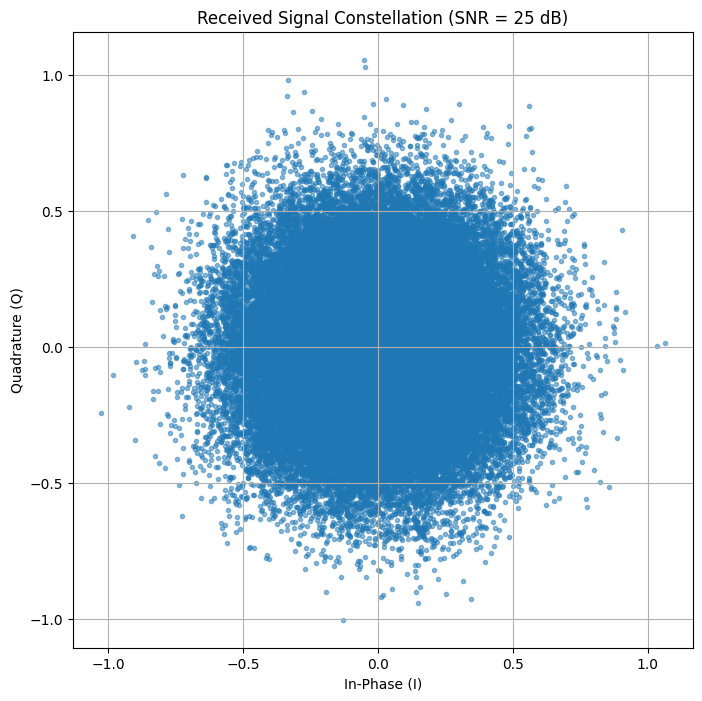

In [21]:
#Plotting the received Signal post-awgn addition
plt.figure(figsize=(8, 8))
plt.scatter(np.real(rxSig), np.imag(rxSig), alpha=0.5, marker='.')
plt.title(f'Received Signal Constellation (SNR = {SNR} dB)')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.grid(True)
plt.show()

## 4. OFDM Receiver <a class="anchor" id="ofdmrx"></a>

An illustration of the OFDM receiver steps is shown below:


<figure>
<img src="https://github.com/tvy14/RFSoC-Book/blob/main/rfsoc_book/notebooks/notebook_I/images/ofdm_rx%20copy.svg?raw=1" style="width: 1000px;"/>
    <figcaption><b>Figure 3: OFDM receiver design.</b></figcaption>
</figure>

We will start by extracting the L-LTF symbols and demodulating them using the FFT. These will be used for channel estimation purposes. In this example, we know the exact timing of the beginning of each symbol. However, in practice, this is unknown and an appropriate timing synchronisation algorithm must be used to acquire symbol timing. Also, due to oscillator offsets between transmitter and receiver and Doppler effects, a frequency synchronisation stage must be performed prior to the FFT in order to minimise the potential for Inter Carrier Interference (ICI).  

The beginning of the first L-LTF OFDM symbol is sample 33 i.e. immediately after the 32 sample CP:

In [13]:
# Extract received L-LTF OFDM symbols
rx_LLTF_symb_1 = rxSig[32:96]
rx_LLTF_symb_2 = rxSig[96:160]

Let's now take the FFT of each of them to recover the transmitted sequences:

In [14]:
LLTF_symb_demod_1 = np.fft.fftshift(np.fft.fft(rx_LLTF_symb_1,N))
LLTF_symb_demod_2 = np.fft.fftshift(np.fft.fft(rx_LLTF_symb_2,N))

Ok, we'll leave these here for now and return to them when we do channel estimation. Now let's extract the data payload OFDM symbols and perform FFTs to recover the underlying data symbols. The CP is removed because it does not contain any information.

In [15]:
# Function to demodulate OFDM
def ofdm_demod(ofdm_rx,N,cp_len):

    # Remove CP
    ofdm_u = ofdm_rx[cp_len:(N+cp_len)]

    # Perform FFT
    data = np.fft.fftshift(np.fft.fft(ofdm_u,N))

    return data

# Array to hold recovered  data symbols
data_rx = np.zeros(n_ofdm*n_data,np.complex64)
j = 0
k = 0

# Extract data payload (after end of L-LTF)
L = len(rxSig)
rxPayload = rxSig[160:L:1]

# Demodulate OFDM symbols in payload
for i in range(n_ofdm):

    # Demodulate OFDM symbols
    rx_demod = ofdm_demod(rxPayload[k:(k+N+cp_len)],N,cp_len)

    # Extract data symbols
    data_rx[j:j+n_data] = rx_demod[index]

    j = j + n_data
    k = k + N + cp_len

### 4.1. Channel Estimation <a class="anchor" id="chanest"></a>

At this stage, we will perform channel estimation. Recall that the channel effect is reduced to a single complex multiplication per sub-carrier. The received symbol on sub-carrier $k$, $Y[k]$, in any given OFDM symbol is given by:    

$$ Y[k] = H[k]X[k] + W[k],$$

where $X[k]$ is the $k^{th}$ transmitted data symbol, $H[k]$ is the frequency response at sub-carrier $k$ and $W[k]$ is the noise at sub-carrier $k$.  

The data symbols transmitted in the L-LTF symbols are known to the receiver. Therefore, we can estimate the channel by dividing through by $X[k]$, leading to:

$$ \hat{H}[k] = \frac{Y[k]}{X[k]} = H[k] + \frac{W[k]}{X[k]} = H[k] + \alpha_{k}, $$

where $\hat{H}[k]$ is the $k^{th}$ channel estimate. The quantity $W[k]/X[k]$ is an unwanted noise term which we denote as $\alpha_{k}$. Since we have two OFDM symbols in the L-LTF, we can generate two channel estimates. Let's extract the symbols on the data sub-carriers, since the null sub-carriers don't carry any information:

In [16]:
# Extract data sub-carriers
LLTF_data_1 = LLTF_symb_demod_1[index]
LLTF_data_2 = LLTF_symb_demod_2[index]

In [17]:
# Get channel estimates
h_1 = LLTF_data_1 / LTFseq[index]
h_2 = LLTF_data_2 / LTFseq[index]

Since the channel effect is not changing over time, we can average $h_{1}$ and $h_{2}$ to produce a final channel estimate:

In [18]:
# Average h_1 and h_2 to get final estimate
h_final = (h_1 + h_2) / 2

Taking an average of the two estimates reduces the effects of noise. As alluded to previously, using the L-LTF for channel estimation assumes that the channel response does not change between the start of the L-LTF and the end of the data payload. This is a reasonable assumption for typical Wi-Fi deployments.  

Let's now compare the estimated magnitude and phase responses of the channel at the data sub-carriers, with the actual magnitude and phase responses of the channel at these positions:

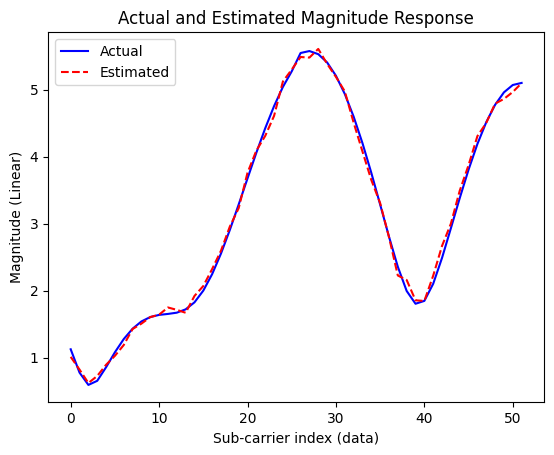

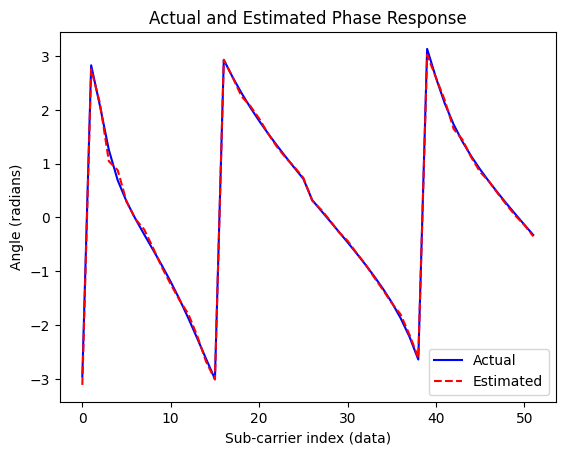

In [19]:
# Calculate magnitude and phase response of channel
chan = np.fft.fftshift(np.fft.fft(h,N))
chan_data = chan[index]

# Plot actual and estimated magnitude response
plt.plot(abs(chan_data),'b')
plt.plot(abs(h_final),'--r')
plt.title('Actual and Estimated Magnitude Response')
plt.xlabel('Sub-carrier index (data)')
plt.ylabel('Magnitude (Linear)')
plt.legend(('Actual','Estimated'))

plt.figure(2)

# Plot actual and estimated phase response
plt.plot(np.angle(chan_data),'b')
plt.plot(np.angle(h_final),'--r')
plt.title('Actual and Estimated Phase Response')
plt.xlabel('Sub-carrier index (data)')
plt.ylabel('Angle (radians)')
plt.legend(('Actual','Estimated'))

The sub-carrier index has been changed to 0 to 51, since there are a total of 52 data sub-carriers. As you decrease the SNR, you'll notice that the difference between the actual and estimated frequency responses increases. This is because when the noise power increases, $\alpha_{k}$ also increases. As shown above, the contribution of $\alpha_{k}$ can be reduced by averaging the channel estimates for the $k^{th}$ sub-carrier over time. The number of available channel estimates to be averaged depends on how regularly the channel is estimated and the length of time over which the channel repsonse remains constant.     

### 4.2. Channel Equalisation <a class="anchor" id="chaneq"></a>

In OFDM, there are two common equalisation methods; the one-tap or Zero Forcing (ZF) equaliser and the Minimum Mean Square Error (MMSE) equaliser. At this stage, we will restrict our discussion to the ZF equaliser. The MMSE will be introduced in a further iteration of the notebook.   

The one-tap or ZF equaliser is the most computationally efficient equalisation method. It is given by:

$$ \hat{X}[k] = \frac{Y[k]}{\hat{H}[k]}. $$

Before expanding the above equation, let's assume that sufficient time averaging of channel estimates has been performed such that $\alpha_{k} = 0$. This will simplify the expanded expression. Therefore, we arrive at:

$$ \hat{X}[k] = \frac{Y[k]}{\hat{H}[k]} = \frac{X[k]H[k] + W[k]}{H[k]} = X[k] + \frac{W[k]}{H[k]}.$$

Inspecting the above, we see that the equalised symbol includes an error term, $W[k]/H[k]$. This error term has a detrimental effect on the performance of the ZF equaliser because when $|H[k]|$ is close to zero, i.e. when the channel is in a deep fade, the $W[k]$ or noise term is amplified. Moreover, as the noise power increases, the amplification has a more severe effect. These issues lead to an SNR degradation after the ZF equaliser.

Based on the procedure for complex division, the ZF equaliser can be re-written as:

$$ \hat{X}[k] = Y[k]\frac{\hat{H}^{*}[k]}{|\hat{H}[k]|^{2}}, $$

where * denotes complex conjugation. The term $\frac{\hat{H}^{*}[k]}{|\hat{H}[k]|^{2}}$ is referred to as the ZF equaliser gain.

Let's now inspect the received constellation before applying the ZF equaliser.  

<Axes: title={'center': 'Constellation plot'}, xlabel='Channel 1 amplitude', ylabel='Channel 2 amplitude'>

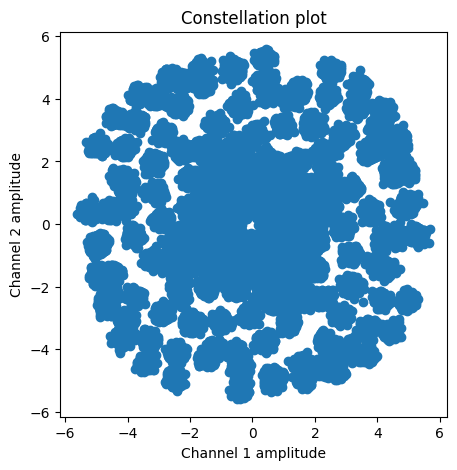

In [20]:
# Plot constellation
scatterplot(data_rx.real,data_rx.imag,ax=None)

It is clear that the received constellations are heavily distorted. Without equalisation, this would lead to a large number of symbol and bit errors. In the next cell, we will equalise the data symbols using the channel estimate from the previous section:

In [21]:
# Equalise data symbols
data_eq_zf = np.zeros(n_ofdm*n_data,np.complex64)
j = 0

for i in range (n_ofdm):

    data_eq_zf[j:j+n_data] = data_rx[j:j+n_data] * (np.conj(h_final)/abs(h_final)**2)

    j = j + n_data

<Axes: title={'center': 'Constellation plot'}, xlabel='Channel 1 amplitude', ylabel='Channel 2 amplitude'>

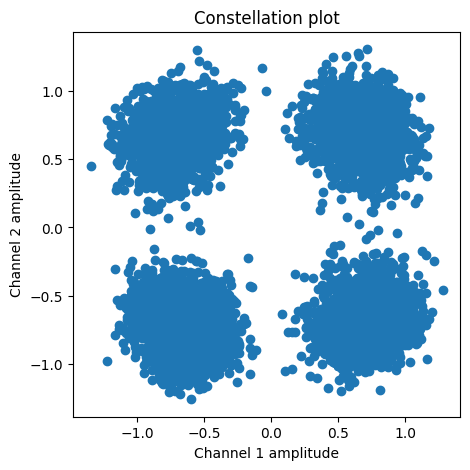

In [22]:
# Plot constellation
scatterplot(data_eq_zf.real,data_eq_zf.imag,ax=None)

### Added Feature called MMSE-IRC (Minimum Mean Square Error with Interference Rejection Combining

<Axes: title={'center': 'Constellation plot'}, xlabel='Channel 1 amplitude', ylabel='Channel 2 amplitude'>

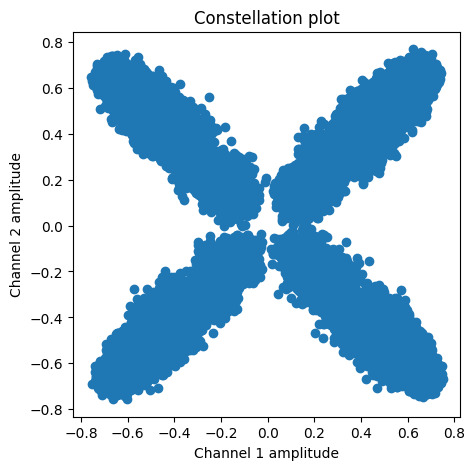

In [27]:
#Using MMSE-IRC (Interference Ratio Combining)

# Equalise data symbols using ZF (already implemented)
data_eq_zf = np.zeros(n_ofdm * n_data, np.complex64)
j = 0

for i in range(n_ofdm):
    data_eq_zf[j : j + n_data] = data_rx[j : j + n_data] * (np.conj(h_final) / abs(h_final) ** 2)
    j = j + n_data


# INSERT MMSE-IRC HERE
def mmse_equalizer(
    data_symbols_per_ofdm, h_final, noise_var, interference_cov=None
):
    """
    MMSE-IRC equalizer implementation
    data_symbols_per_ofdm: received data symbols for a single OFDM symbol (shape (n_data,))
    h_final: channel estimate for data sub-carriers (shape (n_data,))
    noise_var: estimated noise variance
    interference_cov: estimated interference covariance (optional)
    """
    if interference_cov is None:
        # Standard MMSE when no interference covariance available
        mmse_gain = np.conj(h_final) / (np.abs(h_final) ** 2 + noise_var)
    else:
        # MMSE-IRC with interference rejection (not fully implemented here, requires matrix operations)
        # For a simple per-subcarrier MMSE-IRC, the denominator might involve interference_cov per subcarrier
        # This simple implementation assumes interference_cov is a scalar or a vector per subcarrier
        h_hermitian = np.conj(h_final)
        denominator = np.abs(h_final) ** 2 + noise_var + interference_cov  # Assuming interference_cov is broadcastable
        mmse_gain = h_hermitian / denominator

    # Apply the gain to the data symbols for this OFDM symbol
    return data_symbols_per_ofdm * mmse_gain


# Apply MMSE-IRC equalization
noise_var = 2.0  # Estimate from SNR
data_eq_mmse_irc = np.zeros(n_ofdm * n_data, np.complex64)
j = 0

for i in range(n_ofdm):
    # Extract data symbols for the current OFDM symbol
    current_ofdm_data_rx = data_rx[j : j + n_data]

    # Apply MMSE equalization for the current OFDM symbol
    equalized_data_symbols = mmse_equalizer(current_ofdm_data_rx, h_final, noise_var)

    # Store the equalized symbols
    data_eq_mmse_irc[j : j + n_data] = equalized_data_symbols

    # Increment
    j = j + n_data

# Now you can plot the constellation of data_eq_mmse_irc
scatterplot(data_eq_mmse_irc.real, data_eq_mmse_irc.imag, ax=None)

 # Add EVM
 We need to apply the calculate_evm function to the transmitted data symbols (data) and the equalized data symbols from the ZF equalizer (data_eq_zf). The calculate_evm function is already imported and used for the Turbo Equalizer, so you just need to add a similar call for the ZF equalized data.

ZF Equalizer EVM: 12.06%


<Axes: title={'center': 'Constellation plot'}, xlabel='Channel 1 amplitude', ylabel='Channel 2 amplitude'>

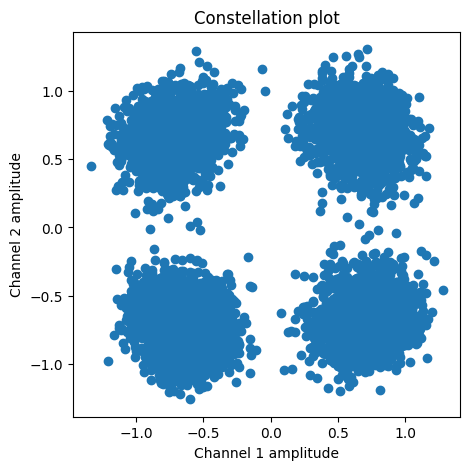

In [28]:
# Equalise data symbols using ZF (already implemented)
data_eq_zf = np.zeros(n_ofdm * n_data, np.complex64)
j = 0

for i in range(n_ofdm):
    data_eq_zf[j : j + n_data] = data_rx[j : j + n_data] * (np.conj(h_final) / abs(h_final) ** 2)
    j = j + n_data

# Calculate and display performance for ZF Equalizer
evm_zf = calculate_evm(data, data_eq_zf)
print(f"ZF Equalizer EVM: {evm_zf:.2f}%")

# INSERT MMSE-IRC HERE
def mmse_equalizer(
    data_symbols_per_ofdm, h_final, noise_var, interference_cov=None
):
    """
    MMSE-IRC equalizer implementation
    data_symbols_per_ofdm: received data symbols for a single OFDM symbol (shape (n_data,))
    h_final: channel estimate for data sub-carriers (shape (n_data,))
    noise_var: estimated noise variance
    interference_cov: estimated interference covariance (optional)
    """
    if interference_cov is None:
        # Standard MMSE when no interference covariance available
        mmse_gain = np.conj(h_final) / (np.abs(h_final) ** 2 + noise_var)
    else:
        # MMSE-IRC with interference rejection (not fully implemented here, requires matrix operations)
        # For a simple per-subcarrier MMSE-IRC, the denominator might involve interference_cov per subcarrier
        # This simple implementation assumes interference_cov is a scalar or a vector per subcarrier
        h_hermitian = np.conj(h_final)
        denominator = np.abs(h_final) ** 2 + noise_var + interference_cov  # Assuming interference_cov is broadcastable
        mmse_gain = h_hermitian / denominator

    # Apply the gain to the data symbols for this OFDM symbol
    return data_symbols_per_ofdm * mmse_gain


# Apply MMSE-IRC equalization
# Estimate noise variance from SNR
# Corrected variable name from snr_db to SNR
snr_linear = 10**(SNR/10)
noise_var = 1.0 / snr_linear

data_eq_mmse_irc = np.zeros(n_ofdm * n_data, np.complex64)
j = 0

for i in range(n_ofdm):
    # Extract data symbols for the current OFDM symbol
    current_ofdm_data_rx = data_rx[j : j + n_data]

    # Apply MMSE equalization for the current OFDM symbol
    equalized_data_symbols = mmse_equalizer(current_ofdm_data_rx, h_final, noise_var)

    # Store the equalized symbols
    data_eq_mmse_irc[j : j + n_data] = equalized_data_symbols

    # Increment
    j = j + n_data

# Now you can plot the constellation of data_eq_mmse_irc
scatterplot(data_eq_mmse_irc.real, data_eq_mmse_irc.imag, ax=None)

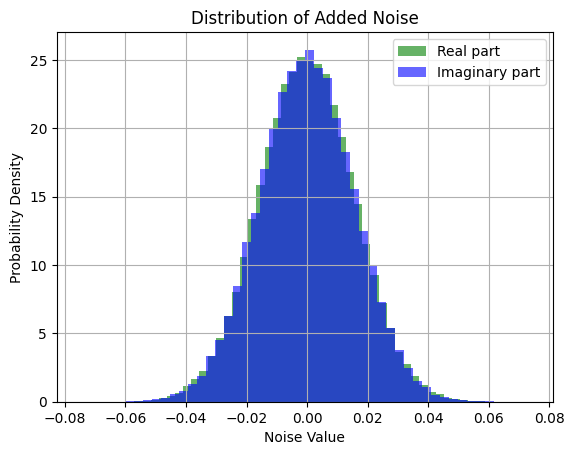

In [25]:
# Calculate the received signal without noise (transmitted signal through channel)
received_signal_no_noise = txSig_filt

# Calculate the noise by subtracting the noise-free received signal from the actual received signal
added_noise = rxSig - received_signal_no_noise

# Now you can plot the distribution of the 'added_noise'
plt.figure()
plt.hist(added_noise.real, bins=50, density=True, alpha=0.6, color='g', label='Real part')
plt.hist(added_noise.imag, bins=50, density=True, alpha=0.6, color='b', label='Imaginary part')
plt.title('Distribution of Added Noise')
plt.xlabel('Noise Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
def turbo_equalizer_fixed(data_rx, h_final, noise_var, mod_scheme='QPSK', n_iterations=3):
    """
    Complete turbo equalization implementation for RFSoC OFDM
    """
    n_data = len(h_final)  # Number of data subcarriers per OFDM symbol
    n_ofdm = len(data_rx) // n_data  # Number of OFDM symbols

    # Reshape data for symbol-by-symbol processing
    data_rx_reshaped = data_rx.reshape(n_ofdm, n_data)
    data_eq_turbo = np.zeros_like(data_rx_reshaped)

    # Initialize extrinsic information
    if mod_scheme == 'QPSK':
        bits_per_symbol = 2
    else:
        bits_per_symbol = 1  # BPSK

    extrinsic_info = np.zeros(n_ofdm * n_data * bits_per_symbol)

    for iteration in range(n_iterations):
        print(f"Turbo iteration {iteration + 1}/{n_iterations}")

        # Process each OFDM symbol
        for ofdm_idx in range(n_ofdm):
            symbol_data = data_rx_reshaped[ofdm_idx, :]

            if iteration == 0:
                # First iteration: no a priori information
                a_priori_mean = np.zeros_like(symbol_data)
                a_priori_var = np.ones_like(symbol_data)
            else:
                # Use feedback from previous iteration
                start_idx = ofdm_idx * n_data
                end_idx = (ofdm_idx + 1) * n_data
                symbol_extrinsic = extrinsic_info[start_idx*bits_per_symbol:end_idx*bits_per_symbol]

                if mod_scheme == 'QPSK':
                    # Placeholder for LLR to symbols conversion for QPSK
                    # This function needs to be defined or imported
                    a_priori_mean, a_priori_var = llr_to_symbols_qpsk(symbol_extrinsic)
                else:
                    # BPSK case
                    a_priori_mean = np.tanh(symbol_extrinsic / 2) / np.sqrt(2)
                    a_priori_var = (1 - np.tanh(symbol_extrinsic / 2)**2) / 2

            # MMSE equalization with a priori information
            denominator = np.abs(h_final)**2 + noise_var + a_priori_var
            mmse_gain = np.conj(h_final) / denominator

            # Apply equalization
            innovation = symbol_data - h_final * a_priori_mean
            data_eq_turbo[ofdm_idx, :] = innovation * mmse_gain + a_priori_mean

            # Soft demapping
            if mod_scheme == 'QPSK':
                # Placeholder for QPSK soft demapper
                # This function needs to be defined or imported
                llr_output = soft_demapper_qpsk(data_eq_turbo[ofdm_idx, :], noise_var)
            else:
                # BPSK soft demapping
                llr_output = 4 * data_eq_turbo[ofdm_idx, :].real / (noise_var * np.sqrt(2))

            # SISO decoder
            start_idx = ofdm_idx * n_data * bits_per_symbol
            end_idx = (ofdm_idx + 1) * n_data * bits_per_symbol
            symbol_extrinsic_in = extrinsic_info[start_idx:end_idx]

            # Placeholder for SISO decoder
            # This function needs to be defined or imported
            decoded_llr, extrinsic_out = siso_decoder_simple(llr_output, symbol_extrinsic_in)

            # Update extrinsic information for next iteration
            extrinsic_info[start_idx:end_idx] = extrinsic_out

    # Flatten result back to original shape
    return data_eq_turbo.flatten()

# Usage with your RFSoC OFDM code:
# Estimate noise variance from SNR
# Corrected variable name from snr_db to SNR
snr_linear = 10**(SNR/10)
noise_var = 1.0 / snr_linear

# Apply turbo equalization
print("Applying Turbo Equalization...")
data_eq_turbo = turbo_equalizer_fixed(data_rx, h_final, noise_var, mod_scheme, n_iterations=3)

# Calculate and display performance
evm_turbo = calculate_evm(data, data_eq_turbo)
print(f"Turbo Equalizer EVM: {evm_turbo:.2f}%")

# Plot constellation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
scatterplot(data_eq_zf.real, data_eq_zf.imag, ax=plt.gca())
plt.title(f'ZF Equalizer')

plt.subplot(1, 2, 2)
scatterplot(data_eq_turbo.real, data_eq_turbo.imag, ax=plt.gca())
plt.title(f'Turbo Equalizer')
plt.tight_layout()
plt.show()

Applying Turbo Equalization...
Turbo iteration 1/3


NameError: name 'soft_demapper_qpsk' is not defined

## EVM Comparison
The primary fix is to correctly calculate llr_output in the QPSK case so that it is a 1D array of LLRs for all bits in the current OFDM symbol, consistent with the shape of symbol_extrinsic_in. This requires a proper soft demapper implementation for QPSK. Since the original code includes a comment about needing to implement or import soft_demapper_qpsk, we will replace the placeholder calculation with a call to this (assumed or to-be-implemented) function.

Additionally, the placeholder for llr_to_symbols_qpsk is also incorrect. A proper LLR to symbol conversion function is needed for the a priori mean and variance calculation in the QPSK case. We will replace this placeholder as well.

For the purpose of making the code executable and demonstrating the structure, we will add minimal placeholder implementations for llr_to_symbols_qpsk and soft_demapper_qpsk that return arrays with the correct shapes, even if the calculations within them are not yet the mathematically correct ones for a full Turbo Equalizer. We will need to replace these placeholders with proper implementations for the Turbo Equalizer to function as intended.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal

# Import helper functions (ensure these are available or implemented)
from rfsoc_book.helper_functions import symbol_gen, psd, \
frequency_plot, scatterplot, calculate_evm, awgn

# Placeholder functions for Turbo Equalizer (replace with proper implementations)
def llr_to_symbols_qpsk(llr):
    """
    Placeholder for LLR to symbols conversion for QPSK.
    Needs a proper implementation.
    Input LLR is a 1D array of LLRs for bits (length n_data * bits_per_symbol).
    Output mean and variance should be for symbols (length n_data).
    """
    # This is a simplified placeholder, NOT the correct mathematical calculation
    # For QPSK (2 bits per symbol), group LLRs
    n_bits_per_symbol = 2
    n_symbols = len(llr) // n_bits_per_symbol
    llr_reshaped = llr.reshape(n_symbols, n_bits_per_symbol)

    # Simple placeholder calculation: average LLRs for a symbol
    # In a real implementation, you would calculate the expected value (mean)
    # and variance of the symbol based on the bit LLRs and constellation mapping.
    a_priori_mean = np.mean(np.tanh(llr_reshaped / 2), axis=1) # Placeholder calculation
    a_priori_var = np.mean((1 - np.tanh(llr_reshaped / 2)**2), axis=1) / 2 # Placeholder calculation

    # Ensure output shapes are correct (n_symbols,)
    return a_priori_mean, a_priori_var

def soft_demapper_qpsk(equalized_symbols, noise_var):
    """
    Placeholder for QPSK soft demapper.
    Needs a proper implementation.
    Input equalized_symbols is a 1D array of symbols (length n_data).
    Output LLR is a 1D array of LLRs for bits (length n_data * bits_per_symbol).
    """
    # This is a simplified placeholder, NOT the correct mathematical calculation
    # In a real implementation, you would calculate the LLRs for each bit
    # based on the received symbol, channel estimate, noise variance, and
    # the a priori LLRs from the decoder feedback.
    n_bits_per_symbol = 2
    n_symbols = len(equalized_symbols)

    # Simple placeholder calculation: linear scaling of real/imaginary parts
    # In a real implementation, this involves calculating conditional probabilities
    # or using approximation methods.
    llr_output = np.zeros(n_symbols * n_bits_per_symbol)
    llr_output[0::2] = 4 * equalized_symbols.real / noise_var # Placeholder for I-bit LLR
    llr_output[1::2] = 4 * equalized_symbols.imag / noise_var # Placeholder for Q-bit LLR

    # Ensure output shape is correct (n_symbols * n_bits_per_symbol,)
    return llr_output

def siso_decoder_simple(llr_input, extrinsic_in):
    """
    Placeholder for a simple SISO decoder.
    Needs a proper implementation (e.g., Viterbi or BCJR algorithm for a specific code).
    Input llr_input and extrinsic_in are 1D arrays of LLRs.
    Output decoded_llr and extrinsic_out are 1D arrays of LLRs.
    """
    # This is a very simplistic placeholder, NOT a real SISO decoder.
    # A real SISO decoder would process the input LLRs (from the demapper)
    # and the a priori LLRs (extrinsic_in from the previous iteration of the decoder)
    # based on the code's trellis or parity check matrix, and output updated
    # LLRs and extrinsic information.

    # Simple placeholder: output is sum of inputs, extrinsic is output minus input extrinsic
    # In a real decoder, extrinsic_out is typically output_LLR - a_priori_LLR
    decoded_llr = llr_input + extrinsic_in # Placeholder
    extrinsic_out = decoded_llr - extrinsic_in # Placeholder for extrinsic calculation (matches definition)

    return decoded_llr, extrinsic_out


# Existing code setup (assuming previous cells have been run)
# fs = 20e6
# N = 64
# ... (other OFDM parameters and txSig generation)
# ... (channel filtering and AWGN)
# ... (rxSig, rx_LLTF_symb_1, rx_LLTF_symb_2 extraction and demodulation)
# ... (LLTF_data_1, LLTF_data_2, h_1, h_2, h_final calculation)
# ... (data_rx extraction and demodulation)
# ... (ZF equalization)
# ... (SNR, snr_linear, noise_var calculation)


# Calculate and display performance for ZF Equalizer
# Assumes 'data' and 'data_eq_zf' are already defined from previous cells
evm_zf = calculate_evm(data, data_eq_zf)
print(f"ZF Equalizer EVM: {evm_zf:.2f}%")

def turbo_equalizer_fixed(data_rx, h_final, noise_var, mod_scheme='QPSK', n_iterations=3):
    """
    Complete turbo equalization implementation for RFSoC OFDM
    """
    n_data = len(h_final)  # Number of data subcarriers per OFDM symbol
    n_ofdm = len(data_rx) // n_data  # Number of OFDM symbols

    # Reshape data for symbol-by-symbol processing
    data_rx_reshaped = data_rx.reshape(n_ofdm, n_data)
    data_eq_turbo = np.zeros_like(data_rx_reshaped)

    # Initialize extrinsic information
    if mod_scheme == 'QPSK':
        bits_per_symbol = 2
    else:
        bits_per_symbol = 1  # BPSK

    # extrinsic_info should hold LLRs for each bit for all OFDM symbols
    extrinsic_info = np.zeros(n_ofdm * n_data * bits_per_symbol)

    for iteration in range(n_iterations):
        print(f"Turbo iteration {iteration + 1}/{n_iterations}")

        # Process each OFDM symbol
        for ofdm_idx in range(n_ofdm):
            symbol_data = data_rx_reshaped[ofdm_idx, :]

            if iteration == 0:
                # First iteration: no a priori information (LLRs are 0)
                # a_priori_mean and a_priori_var are derived from a priori LLRs
                # When a priori LLRs are 0, mean is 0 and variance is 1 for normalized BPSK/QPSK symbols
                a_priori_mean = np.zeros_like(h_final) # Shape (n_data,)
                a_priori_var = np.ones_like(h_final)   # Shape (n_data,)
            else:
                # Use feedback from previous iteration (extrinsic from decoder)
                start_bit_idx = ofdm_idx * n_data * bits_per_symbol
                end_bit_idx = (ofdm_idx + 1) * n_data * bits_per_symbol
                # symbol_extrinsic holds the extrinsic LLRs for all bits of the current OFDM symbol
                symbol_extrinsic = extrinsic_info[start_bit_idx:end_bit_idx]

                if mod_scheme == 'QPSK':
                    # Convert bit LLRs (symbol_extrinsic) to symbol mean and variance
                    # using the placeholder or a proper llr_to_symbols_qpsk function
                    a_priori_mean, a_priori_var = llr_to_symbols_qpsk(symbol_extrinsic)
                else:
                    # BPSK case
                    # For BPSK, mean is tanh(LLR/2), variance is (1 - tanh(LLR/2)^2)/2
                    # since there's one bit per symbol, the mean/variance are directly from the bit LLRs
                    a_priori_mean = np.tanh(symbol_extrinsic / 2) / np.sqrt(2) # Ensure this is shape (n_data,)
                    a_priori_var = (1 - np.tanh(symbol_extrinsic / 2)**2) / 2 # Ensure this is shape (n_data,)


            # MMSE equalization with a priori information
            # Ensure shapes are compatible for denominator calculation
            # h_final, noise_var, and a_priori_var must have shape (n_data,)
            # symbol_data has shape (n_data,)
            # a_priori_mean must have shape (n_data,)

            # Check if a_priori_mean and a_priori_var have the correct shape (n_data,)
            if a_priori_mean.shape != (n_data,):
                 raise ValueError(f"a_priori_mean has incorrect shape {a_priori_mean.shape}, expected {(n_data,)}")
            if a_priori_var.shape != (n_data,):
                 raise ValueError(f"a_priori_var has incorrect shape {a_priori_var.shape}, expected {(n_data,)}")

            denominator = np.abs(h_final)**2 + noise_var + a_priori_var
            mmse_gain = np.conj(h_final) / denominator

            # Apply equalization
            innovation = symbol_data - h_final * a_priori_mean
            data_eq_turbo[ofdm_idx, :] = innovation * mmse_gain + a_priori_mean

            # Soft demapping (produces LLRs for bits based on equalized symbols)
            if mod_scheme == 'QPSK':
                # Call the placeholder or proper soft demapper for QPSK
                # It should output a 1D array of bit LLRs (length n_data * bits_per_symbol)
                llr_output = soft_demapper_qpsk(data_eq_turbo[ofdm_idx, :], noise_var)
            else:
                # BPSK soft demapping (outputs LLRs for bits)
                # For BPSK, output LLRs are for n_data bits
                llr_output = 4 * data_eq_turbo[ofdm_idx, :].real / (noise_var * np.sqrt(2))
                # Ensure llr_output has shape (n_data,) for BPSK

            # SISO decoder input LLRs (from demapper) and a priori LLRs (extrinsic from previous decoder output)
            # Both inputs to SISO decoder should be 1D arrays of bit LLRs
            siso_input_llrs = llr_output # LLRs from channel/demapper
            siso_a_priori_llrs = symbol_extrinsic # Extrinsic LLRs from previous decoder iteration

            # SISO decoder (placeholder or proper implementation)
            # It takes input LLRs and a priori LLRs and outputs updated LLRs and extrinsic LLRs
            # The extrinsic_out from the decoder is the a priori information for the *next* iteration's demapper/equalizer
            decoded_llrs, extrinsic_out = siso_decoder_simple(siso_input_llrs, siso_a_priori_llrs)


            # Update extrinsic information for next iteration's demapper/equalizer
            # extrinsic_out should be a 1D array of bit LLRs for the current OFDM symbol
            extrinsic_info[start_bit_idx:end_bit_idx] = extrinsic_out

    # Flatten result back to original shape
    return data_eq_turbo.flatten()

# Usage with your RFSoC OFDM code:
# Estimate noise variance from SNR
# Corrected variable name from snr_db to SNR
snr_linear = 10**(SNR/10)
noise_var = 1.0 / snr_linear

# Apply turbo equalization
print("Applying Turbo Equalization...")
# Assuming data_rx, h_final, noise_var, mod_scheme are defined from previous cells
data_eq_turbo = turbo_equalizer_fixed(data_rx, h_final, noise_var, mod_scheme, n_iterations=3)

# Calculate and display performance for Turbo Equalizer
# Assumes 'data' and 'data_eq_turbo' are defined
evm_turbo = calculate_evm(data, data_eq_turbo)
print(f"Turbo Equalizer EVM: {evm_turbo:.2f}%")

# Plot constellation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# Assumes 'data_eq_zf' is defined
scatterplot(data_eq_zf.real, data_eq_zf.imag, ax=plt.gca())
plt.title(f'ZF Equalizer')

plt.subplot(1, 2, 2)
# Assumes 'data_eq_turbo' is defined
scatterplot(data_eq_turbo.real, data_eq_turbo.imag, ax=plt.gca())
plt.title(f'Turbo Equalizer')
plt.tight_layout()
plt.show()

Try running the notebook several times and look at the received constellation after ZF equalisation. You will notice that even for high SNRs, the constellation can still be very distorted. This becomes especially evident when employing 16-QAM. This is due to the noise amplification that occurs when the  channel experiences deep fades. Have a look at the channel magnitude response to confirm the presence (or not!) of a deep fade. Note, in practice, the use of Forward Error Correction (FEC) in OFDM systems can help to improve the error rate performance in channels with deep fades. It is also possible to reduce the modulation order on sub-carriers affected by a deep fade to improve robustness, if there is a mechanism in place to feedback the Channel State Information (CSI) to the transmitter.

The noise amplification issue associated with the ZF equaliser can be reduced by employing an MMSE equaliser, albeit with an increase in computational complexity.         

## 5. Conclusion <a class="anchor" id="conclusion"></a>

In this notebook, we have demonstrated the major steps in an OFDM transceiver chain. This includes symbol generation, IFFT modulation and CP addition on the transmit side and CP removal, FFT demodulation, channel estimation and one-tap equalisation on
the receive side. The equalised constellations were plotted as a measure of received signal quality.  

---

[⬅️ Previous Notebook](01_ofdm_fundamentals.ipynb) || [Next Notebook 🚀](03_rfsoc_ofdm_transceiver.ipynb)

Copyright © 2023 Strathclyde Academic Media

---
---